<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Autoencoder (CAE) — Baseline Model**

This notebook defines, trains, and evaluates a baseline Convolutional Autoencoder (CAE) on the MNIST dataset. The model serves as a foundation for subsequent experiments exploring architectural variations and training strategies.

---

## 📌 Objective

To implement a minimal convolutional autoencoder capable of reconstructing grayscale handwritten digits, and to establish a reliable performance baseline for future comparisons.

---

## 🔁 Experiment Workflow

1. Clone the project and configure dependencies  
2. Define the baseline model architecture  
3. Train the model over 20 epochs using the Adam optimizer   
4. Analyze training and validation losses, and evaluate reconstruction quality
5. Make conclusion
6. Export results to GitHub

---

## 📊 Key Findings

- Stable convergence achieved in under 10 epochs  
- No signs of overfitting — training and validation losses remain aligned  
- Reconstructed digits are clean, artifact-free, and faithfully preserve original structures
- The baseline model is sufficient for encoding and decoding applications

---

## 1. 🔧 Setup

This section setups and configure project dependencies.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries
- Define constants

## 2. 🧠 Define Model Architecture

This section defines the baseline CAE configuration used as a control in all comparative experiments.

- **Encoder/Decoder channel configuration:** `[32, 32, 64]`  
- **Latent dimension:** `32`  
- **Batch sizes:** 32 (train) / 500 (validation)  
- **Batch normalization:** Not used  
- **Activation function:** ReLU  
- **Optimizer:** Adam (`lr = 1e-3`)  
- **Scheduler:** ReduceLROnPlateau (monitors validation loss and adjusts learning rate)  
- **Training epochs:** 20

## 3. 🏋️‍♀️ Model Training

This section trains the baseline model using the `run_model_training()` function. The function encapsulates the full training loop, including validation checks, learning rate scheduling, and result tracking.

- Trained for `base_num_epoch = 20` epochs  
- Tracked both training and validation loss at each step  
- Applied `ReduceLROnPlateau` scheduler on validation loss  
- Saved model weights and training history

## 4. 🔍 Results and Observations

This section summarizes the training dynamics and reconstruction performance of the baseline CAE model.


### 4.1 📉 Loss Curves Analysis

- Training and validation losses decreased steadily and converged early, within the first 10 epochs — confirming that **20 epochs was more than sufficient**  
- Both curves stabilized at similar magnitudes, indicating well-balanced generalization and **no signs of overfitting**.
- The model's capacity is well matched to the problem complexity

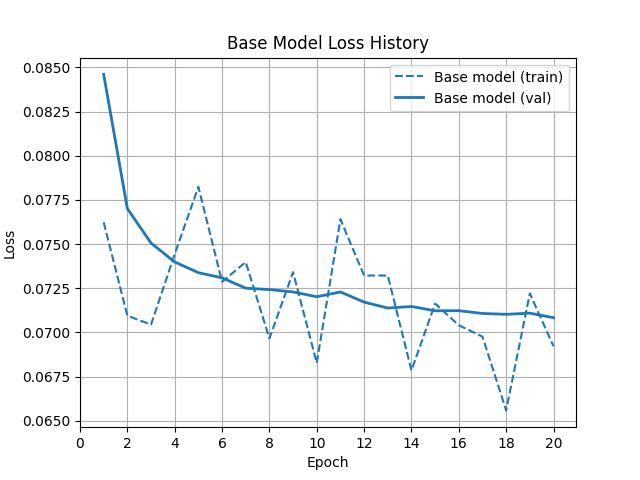

In [32]:
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_loss.png'))

### 4.2 📷 Reconstruction Quality Analysis

- **Reconstruction quality is high and consistent**  
- Reconstructed digits closely match their original counterparts  
- Key visual **features** (shapes, edges, loops) are **accurately captured** across all digits

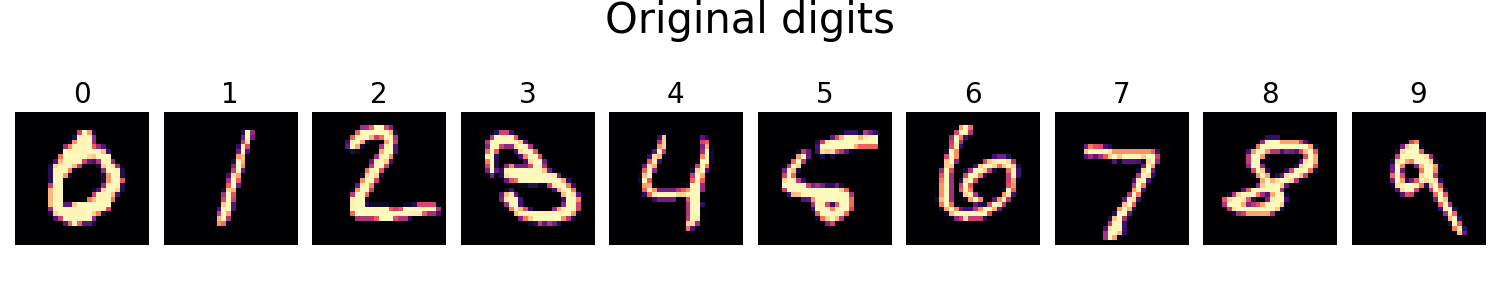

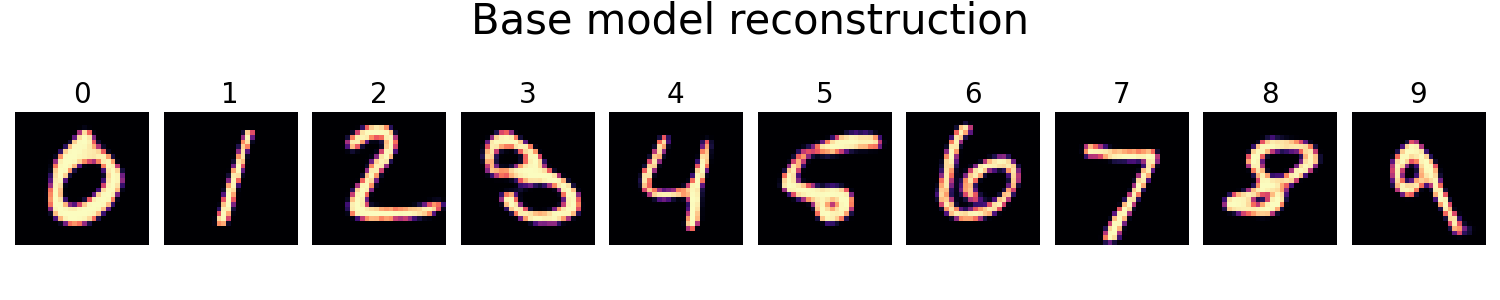

In [33]:
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_original.png'))
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))

### 4.3 🧮 Model Complexity Analysis

The total number of trainable parameters in the baseline CAE is used as a reference point for evaluating model complexity across all experiments.  
This serves as a benchmark for comparing the efficiency of alternative architectures.

📊 **Total Parameters**: ~137K

## 5. ✅ Conclusion

The baseline model demonstrates **stable and consistent learning behavior** across both training and validation sets. Its ability to reconstruct MNIST digits with high fidelity, despite its minimal configuration, **confirms its effectiveness** as a foundational architecture.

Given the simplicity of the MNIST dataset, this model has already reached a state where it can be used efficiently and reliably. It will serve as a **reference point** for evaluating the impact of architectural and training modifications in subsequent experiments.

---
---


# 🛠️ Notebook Workflow

The sections below contain the actual code used to define, train, and evaluate the baseline CAE. This includes model setup, training logic, and result generation. These blocks serve as the working core of the notebook and support the summary presented above.


## 1. 🔧 Setup


In [1]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 810, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 810 (delta 79), reused 69 (delta 43), pack-reused 663 (from 2)
Receiving objects: 100% (810/810), 32.00 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (403/403), done.


In [7]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history

In [3]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

from IPython.display import Image, display

In [4]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Model Architecture


In [5]:
# define baseline model architecture
base_n_channels = [32, 32, 64]
base_latent_dim = 32

# assign batch sizes
base_train_batch_size=32
base_validation_batch_size=500

# assign dataloaders
base_train_dataloader = get_train_dataloader(batch_size=base_train_batch_size, data_dir='../data')
base_validation_dataloader = get_validation_dataloader(batch_size=base_validation_batch_size, data_dir='../data')

# initialize baseline model
base_model = AutoEncoder(
    n_channels=base_n_channels,
    latent_dim=base_latent_dim
).to(device)

# define optimizer for baseline model
base_optimizer = optim.Adam(base_model.parameters(), lr=1e-3)

# define learning rate scheduler (monitors validation loss plateau)
base_scheduler = ReduceLROnPlateau(
    base_optimizer,
    mode='min',
    threshold=1e-3,
    patience=3,
    factor=0.5
)

# define baseline number of training epochs
base_num_epoch = 20

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]


In [6]:
#description of the base model
base_description = f"""
Baseline model configuration:
- Architecture: n_channels = {base_n_channels}, latent_dim = {base_latent_dim}
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: {base_num_epoch} epochs
- Train batch size: {base_train_batch_size}
- Validation batch size: {base_validation_batch_size}
"""
print(base_description.strip())

# print model summary for baseline model
print(summary(base_model, input_size=(1, 28, 28)))

Baseline model configuration:
- Architecture: n_channels = [32, 32, 64], latent_dim = 32
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: 20 epochs
- Train batch size: 32
- Validation batch size: 500
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
          Identity-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]          16,416
          Identity-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
          Identity-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 32]          32,800
           Encoder-9           

## 3. 🏋️‍♀️ Training


In [ ]:
# train the baseline model using default settings
base_model, base_loss = run_model_training(
    model=base_model,
    train_dataloader=base_train_dataloader,
    validation_dataloader=base_validation_dataloader,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    num_epoch=base_num_epoch,
    device=device
)

## 4. 🔍 Results and Observations


### 4.1 📉 Loss Curves

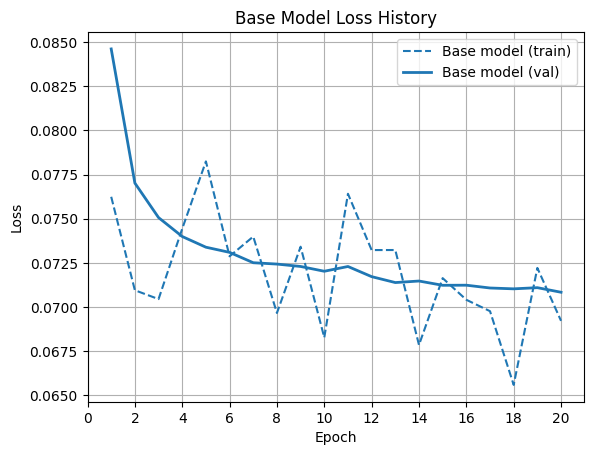

In [14]:
# plot training and validation loss for baseline model
plot_experiment_history([base_loss], label_list=['Base model', 'Base model'], to_plot_train=True)
plt.grid()
plt.xticks(range(0, base_num_epoch + 1, 2))
plt.legend()
plt.title('Base Model Loss History')
plt.savefig("CAE-MNIST/outputs/base_model_files/base_image_loss.png")
plt.show()

In [ ]:
!git -C /content/CAE-MNIST add outputs/base_model_files/base_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add base model loss history curve"
!git -C /content/CAE-MNIST push origin main

### 4.2 📷 Reconstruction Quality Analysis


In [18]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(base_validation_dataloader)

# get reconstructed digits from base model
base_reconstruction = get_experiment_reconstructions([base_model],sample_images, device)

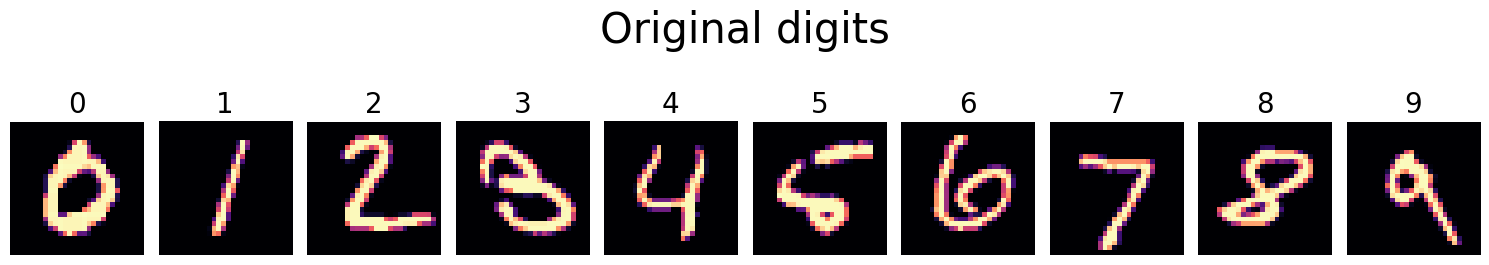

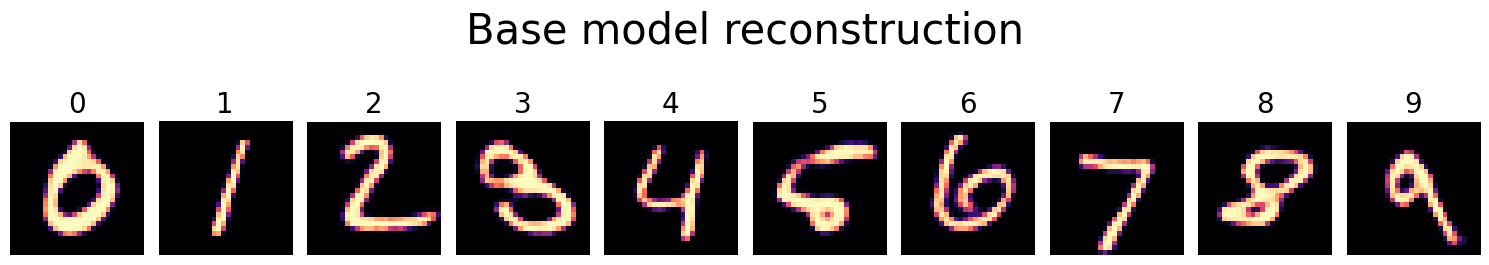

In [22]:
# display original benchmark images
original_fig = plot_digits_row(sample_images.squeeze(), sample_labels, title='Original digits')
original_fig.savefig("CAE-MNIST/outputs/base_model_files/base_image_original.png")

# display reconstructions from base model
reconstruction_figures = plot_experiment_reconstructions(base_reconstruction, sample_labels, title_list=['Base model'])
reconstruction_figures[0].savefig("CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png")

In [23]:
!git -C /content/CAE-MNIST add outputs/base_model_files/base_image_original.png
!git -C /content/CAE-MNIST commit -m "Add original digits"
!git -C /content/CAE-MNIST push origin main

[main 7a3851e] Add original digits
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/base_model_files/base_image_original.png (99%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 19.49 KiB | 9.75 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   26fd6d7..7a3851e  main -> main


In [24]:
!git -C /content/CAE-MNIST add outputs/base_model_files/base_image_reconstruction.png
!git -C /content/CAE-MNIST commit -m "Add reconstructed digits"
!git -C /content/CAE-MNIST push origin main

[main 5333dc0] Add reconstructed digits
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/base_model_files/base_image_reconstruction.png (99%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 24.93 KiB | 12.46 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   7a3851e..5333dc0  main -> main


### 4.3 🧮 Model Complexity Analysis

In [25]:
# dictionary of model parameters in experiment 5
base_param_counts = {}

param_count = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
base_param_counts['base_model'] = param_count

# print model paramets
print(base_param_counts)

{'base_model': 137441}


## 6. 📂 Export Base Model Files

In [26]:
# Local (temporary) export folder
local_export_folder = '/content/CAE_base_model_local'
os.makedirs(local_export_folder, exist_ok=True)

# Save model weights
torch.save(base_model.state_dict(), os.path.join(local_export_folder, 'base_model.pth'))

# Save loss history
torch.save(base_loss, os.path.join(local_export_folder, 'base_loss.pth'))

# Save parameter counts dict
torch.save(base_param_counts, os.path.join(local_export_folder, 'base_param_counts.pth'))

# Save reconstructed images
torch.save(base_reconstruction, os.path.join(local_export_folder, 'base_reconstruction.pth'))

# Save description
with open(os.path.join(local_export_folder, 'base_description.txt'), 'w') as f:
    f.write(base_description.strip())

In [27]:
# Paths
local_export_folder = '/content/CAE_base_model_local'
git_output_folder = '/content/CAE-MNIST/outputs/base_model_files'
files_to_copy = ['base_model.pth', 'base_loss.pth', 'base_description.txt', 'base_param_counts.pth', 'base_reconstruction.pth']

# Copy all files to Git outputs folder (overwrite silently)
os.makedirs(git_output_folder, exist_ok=True)
for file in files_to_copy:
    shutil.copy2(os.path.join(local_export_folder, file),
                 os.path.join(git_output_folder, file))

# Commit and push
%cd /content/CAE-MNIST
!git add outputs/base_model_files/*
!git commit -m "Update base model files"
!git push origin main

/content/CAE-MNIST
[main c25d542] Update base model files
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/base_model_files/base_param_counts.pth
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 786 bytes | 786.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   5333dc0..c25d542  main -> main


## Import Base Model Files

In [29]:
# Paths to files inside the cloned Git repo
outputs_path = '/content/CAE-MNIST/outputs/base_model_files'

# Load model
base_model = AutoEncoder(n_channels=base_n_channels,
                         latent_dim=base_latent_dim)
base_model.load_state_dict(torch.load(os.path.join(outputs_path, 'base_model.pth'), map_location=device))
base_model.eval()

# Load loss history
base_loss = torch.load(os.path.join(outputs_path, 'base_loss.pth'))

# Load param counts dict
base_param_counts = torch.load(os.path.join(outputs_path, 'base_param_counts.pth'))

# Load reconstructed images
base_reconstruction = torch.load(os.path.join(outputs_path, 'base_reconstruction.pth'))

# Load description text
with open(os.path.join(outputs_path, 'base_description.txt'), 'r') as f:
    base_description = f.read()

print("✅ Model, loss history, parameter counts, reconstructed images and description loaded successfully.")

✅ Model, loss history, parameter counts, reconstructed images and description loaded successfully.


## Re-Clone Git Repository

In [28]:
!rm -rf /content/CAE-MNIST
#%cd /content
!git clone {repo_url}

/content
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 830, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 830 (delta 73), reused 60 (delta 25), pack-reused 683 (from 2)
Receiving objects: 100% (830/830), 31.78 MiB | 24.88 MiB/s, done.
Resolving deltas: 100% (421/421), done.
